In [1]:
import numpy as np
import corner
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm
import os
import matplotlib.gridspec as gridspec

import fit_time_dep_fluxes as fit_flux

import matplotlib
#matplotlib.rc('text',usetex=True)
font = {'family' : 'serif',
#        'weight' : 'bold',
        'size'   : 16,}
matplotlib.rc('font', **font)


In [2]:
plotpath = './figures/'
if not os.path.isdir(plotpath):
    os.makedirs(plotpath)


In [3]:
#generate some synthetic data

np.random.seed(101)

n_reads = 42
n_pixels = 100

#define true fluxes in each pixel
true_fluxes = ((np.random.rand(n_pixels)-0.5)*2)*200 + 1000 #high flux case
# true_fluxes = ((np.random.rand(n_pixels)-0.5)*2)*50 + 100 #moderate flux cas
# true_fluxes = ((np.random.rand(n_pixels)-0.5)*2)*2 + 5 #low flux case

#set the read noise in each pixel
read_errs = ((np.random.rand(n_pixels)-0.5)*2)*5 + 28

#define the true multiplicative factor to the fluxes
true_b_vect = np.ones(n_reads-1)*1.0
true_b_vect = np.linspace(0.5,2.0,n_reads-1)
true_b_vect[n_reads//2:] = 1.0
true_b_vect /= true_b_vect.max()

true_b_vect = 1.0 - (np.random.rand(n_reads-1))*0.5

read_times = np.arange(n_reads)
read_diff_times = 0.5*(read_times[1:]+read_times[:-1])

obs_fluxes = fit_flux.generate_data(read_errs,true_fluxes,true_b_vect)

obs_fluxes_errs = np.sqrt(np.power(read_errs,2)+np.maximum(true_fluxes,0))
obs_flux_diffs = np.diff(obs_fluxes,axis=1)
# obs_flux_diff_errs = np.sqrt((read_err*2)**2+np.maximum(true_fluxes[:,1:],0))
obs_flux_diff_errs = np.sqrt(np.power(read_errs*2,2)[:,None]+np.maximum(obs_flux_diffs,0))


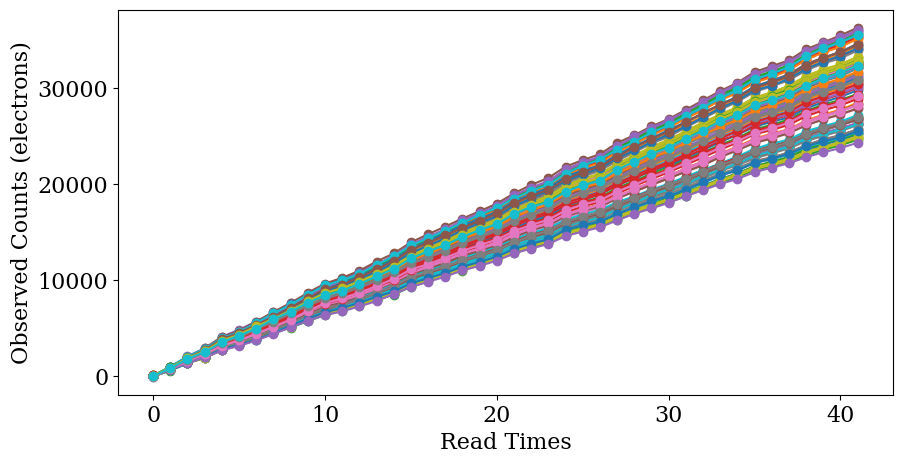

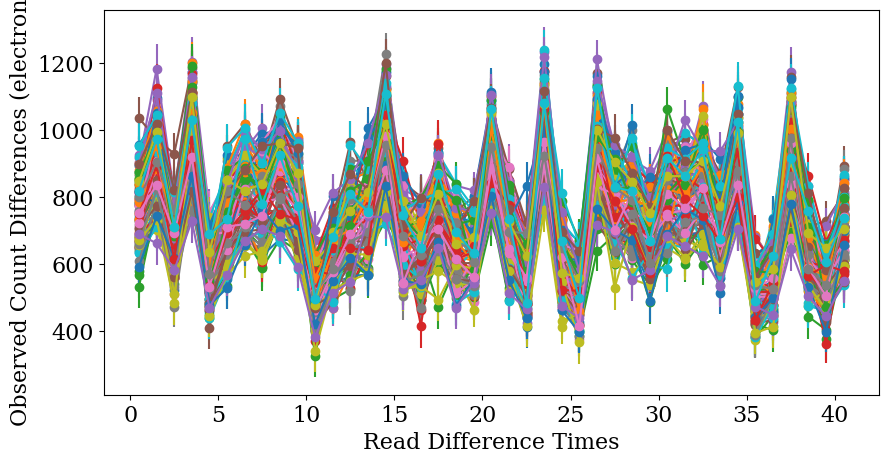

In [4]:

plt.figure(figsize=(10,5))
for j in range(n_pixels):
    plt.errorbar(read_times,obs_fluxes[j],yerr=obs_fluxes_errs[j],fmt='-o')
plt.xlabel('Read Times')
plt.ylabel('Observed Counts (electrons)')
plt.show()

plt.figure(figsize=(10,5))
for j in range(n_pixels):
    plt.errorbar(read_diff_times,obs_flux_diffs[j],yerr=obs_flux_diff_errs[j],fmt='-o')
plt.xlabel('Read Difference Times')
plt.ylabel('Observed Count Differences (electrons)')
plt.show()


In [5]:
max_b_ind,b_vect_mean,b_vect_Vinv,b_vect_V,\
        f_max_means_given_b,f_max_ivars_given_b,\
        comb_param_means,comb_param_Vinv,comb_param_V,comb_param_samps = fit_flux.measure_time_dep_fluxes_GIBBS(obs_fluxes,read_errs,
                                                       n_samples=10000,b_vect_change_tol=1e-10,
                                                       min_b_val=1e-10,min_f_val=1e-10,
                                                       rescale=True,true_b_vect=true_b_vect,
                                                       true_fluxes=true_fluxes,
                                                       use_linear_first_guess=True,
                                                       verbose=True,return_samples=True)

f_means_no_b,f_ivars_no_b,chi2s_data_no_b = fit_flux.fit_fluxes_optimal(obs_fluxes,read_errs,
                                                                           n_repeat=2,b_vect=None)
f_means_with_b,f_ivars_with_b,chi2s_data_with_b = fit_flux.fit_fluxes_optimal(obs_fluxes,read_errs,
                                                                           n_repeat=2,b_vect=b_vect_mean)

non_max_inds = np.ones(len(b_vect_mean)).astype(bool)
non_max_inds[max_b_ind] = False
non_max_inds = np.where(non_max_inds)[0]

b_vect_errs = np.sqrt(np.diag(b_vect_V))
f_max_errs_given_b = np.power(f_max_ivars_given_b,-0.5)

b_vect_mean_gibbs = np.copy(b_vect_mean)
b_vect_errs_gibbs = np.copy(b_vect_errs)
b_vect_cov_gibbs = np.copy(b_vect_V)
comb_param_samps_gibbs = np.copy(comb_param_samps)

Using Gibbs sampling to generate 10000 samples


100%|█████████████████████████████████████| 10000/10000 [02:15<00:00, 73.54it/s]

Done


In [6]:
max_b_ind,b_vect_mean,b_vect_Vinv,b_vect_V,\
        f_max_means_given_b,f_max_ivars_given_b,\
        comb_param_means,comb_param_Vinv,comb_param_V = fit_flux.measure_time_dep_fluxes_LINEAR(obs_fluxes,read_errs,
                                                       n_max_repeat=1000,b_vect_change_tol=1e-10,
                                                       min_b_val=1e-10,min_f_val=1e-10,
                                                       rescale=True,true_b_vect=true_b_vect,
                                                       true_fluxes=true_fluxes)

f_means_no_b,f_ivars_no_b,chi2s_data_no_b = fit_flux.fit_fluxes_optimal(obs_fluxes,read_errs,
                                                                           n_repeat=2,b_vect=None)
f_means_with_b,f_ivars_with_b,chi2s_data_with_b = fit_flux.fit_fluxes_optimal(obs_fluxes,read_errs,
                                                                           n_repeat=2,b_vect=b_vect_mean)

non_max_inds = np.ones(len(b_vect_mean)).astype(bool)
non_max_inds[max_b_ind] = False
non_max_inds = np.where(non_max_inds)[0]

b_vect_errs = np.sqrt(np.diag(b_vect_V))
f_max_errs_given_b = np.power(f_max_ivars_given_b,-0.5)

b_vect_mean_linear = np.copy(b_vect_mean)
b_vect_errs_linear = np.copy(b_vect_errs)
b_vect_cov_linear = np.copy(b_vect_V)

#draw samples from the linearized-method
n_samples = 10000
curr_L = np.linalg.cholesky(comb_param_V)
comb_param_samps = np.einsum('ij,nj->ni',curr_L,np.random.randn(n_samples,len(comb_param_means)))+comb_param_means
comb_param_samps_linear = np.copy(comb_param_samps)

In [7]:
true_param_means = np.zeros_like(comb_param_means)
true_param_means[:n_pixels] = true_fluxes
true_param_means[n_pixels:] = true_b_vect[non_max_inds]

diff = (comb_param_means-true_param_means)
full_chi2 = np.dot(np.dot(diff,comb_param_Vinv),diff)
indv_chi2 = np.sum((np.power(diff,2)/(np.diag(comb_param_V))))

print(full_chi2/len(diff),indv_chi2/len(diff),len(diff))

0.993515499586897 0.5773009675410226 140


In [8]:
diff = (comb_param_means-true_param_means)[:n_pixels]
full_chi2 = np.dot(np.dot(diff,comb_param_Vinv[:n_pixels,:n_pixels]),diff)
indv_chi2 = np.sum((np.power(diff,2)/(np.diag(comb_param_V)[:n_pixels])))

print(full_chi2/len(diff),indv_chi2/len(diff),len(diff))

diff = (f_max_means_given_b-true_fluxes)
indv_chi2 = np.sum((np.power(diff/f_max_errs_given_b,2)))

print(indv_chi2/len(diff),len(diff))


1.0295602660059329 0.5956380525417413 100
1.0337859206349471 100


In [9]:
diff = (comb_param_means-true_param_means)[n_pixels:]
full_chi2 = np.dot(np.dot(diff,comb_param_Vinv[n_pixels:,n_pixels:]),diff)
indv_chi2 = np.sum((np.power(diff,2)/(np.diag(comb_param_V)[n_pixels:])))

print(full_chi2/len(diff),indv_chi2/len(diff),len(diff))

diff = (b_vect_mean-true_b_vect)[non_max_inds]
full_chi2 = np.dot(np.dot(diff,b_vect_Vinv[non_max_inds][:,non_max_inds]),diff)
indv_chi2 = np.sum((np.power(diff,2)/(np.diag(b_vect_V)[non_max_inds])))

print(full_chi2/len(diff),indv_chi2/len(diff),len(diff))


0.9041322537900058 0.5314582550392257 40
0.904132253790006 0.5314582550392257 40


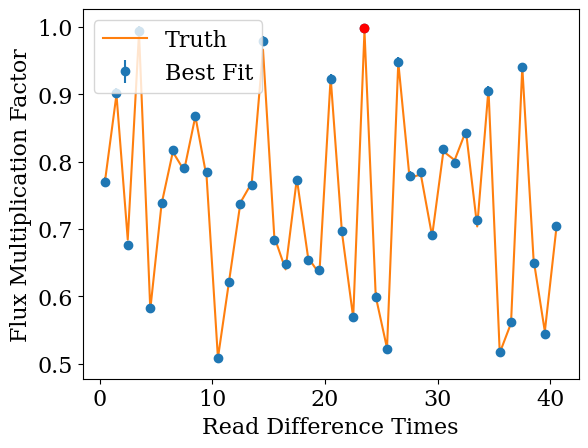

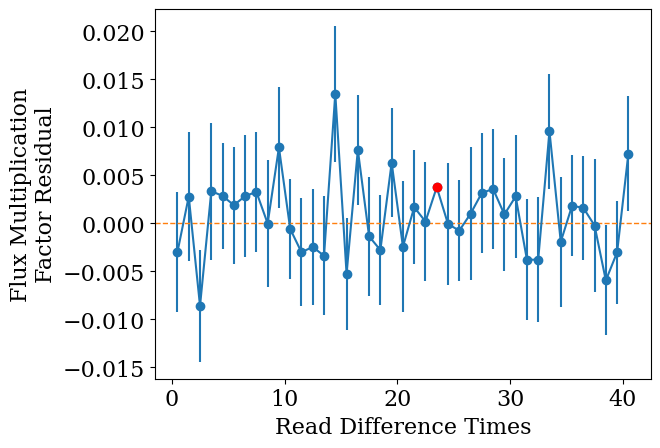

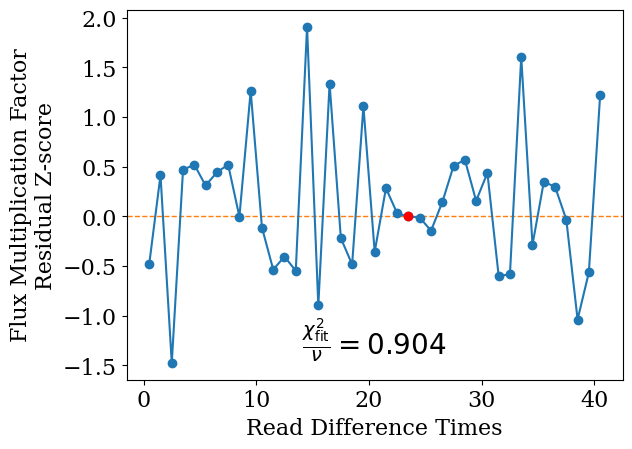

In [10]:
diff = (b_vect_mean-true_b_vect)[non_max_inds]
full_chi2 = np.dot(np.dot(diff,b_vect_Vinv[non_max_inds][:,non_max_inds]),diff)

b_vect_fit_scaled_chi2 = full_chi2/len(diff)
chi2_label = r'$\frac{\chi_{\mathrm{fit}}^2}{\nu} = %.3f$'%b_vect_fit_scaled_chi2

plt.errorbar(read_diff_times,b_vect_mean,yerr=b_vect_errs,fmt='o',label='Best Fit')
plt.errorbar(read_diff_times[max_b_ind],b_vect_mean[max_b_ind],
             yerr=b_vect_errs[max_b_ind],
             fmt='o',color='r')
plt.plot(read_diff_times,true_b_vect,label='Truth')
plt.xlabel('Read Difference Times')
plt.ylabel('Flux Multiplication Factor')
leg = plt.legend(loc='best')
plt.show()

plt.errorbar(read_diff_times,b_vect_mean-true_b_vect,yerr=b_vect_errs,fmt='-o')
plt.errorbar(read_diff_times[max_b_ind],(b_vect_mean-true_b_vect)[max_b_ind],
             yerr=b_vect_errs[max_b_ind],
             fmt='-o',color='r')
plt.axhline(0,c='C1',ls='--',lw=1)
plt.xlabel('Read Difference Times')
plt.ylabel('Flux Multiplication\nFactor Residual')
plt.show()

z_scores = (b_vect_mean-true_b_vect)/b_vect_errs
plt.errorbar(read_diff_times,z_scores,fmt='-o')
plt.errorbar(read_diff_times[max_b_ind],z_scores[max_b_ind],
             fmt='-o',color='r')
plt.text(np.mean(read_diff_times),np.min(z_scores),
         chi2_label,va='bottom',ha='center',fontsize=20)
plt.axhline(0,c='C1',ls='--',lw=1)
plt.xlabel('Read Difference Times')
plt.ylabel('Flux Multiplication Factor\nResidual Z-score')
plt.show()


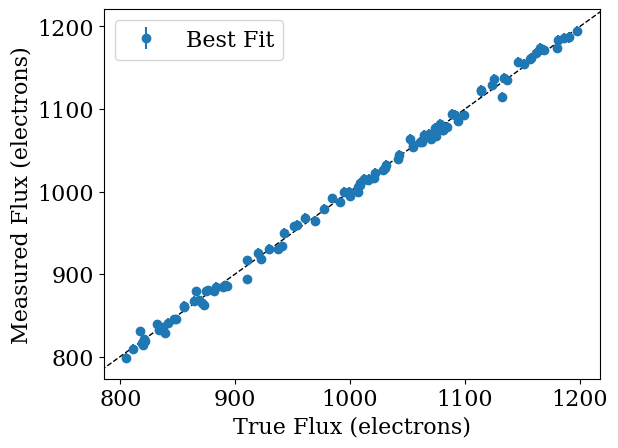

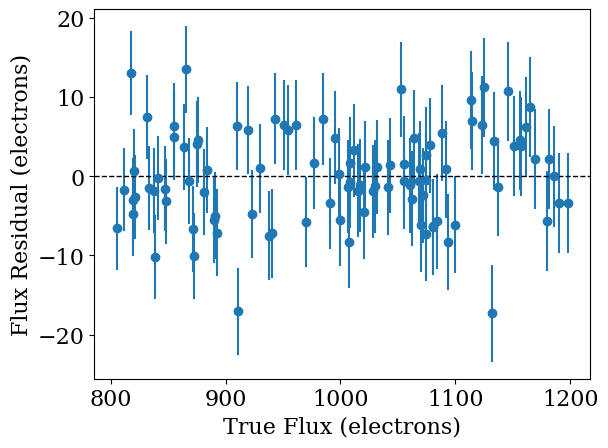

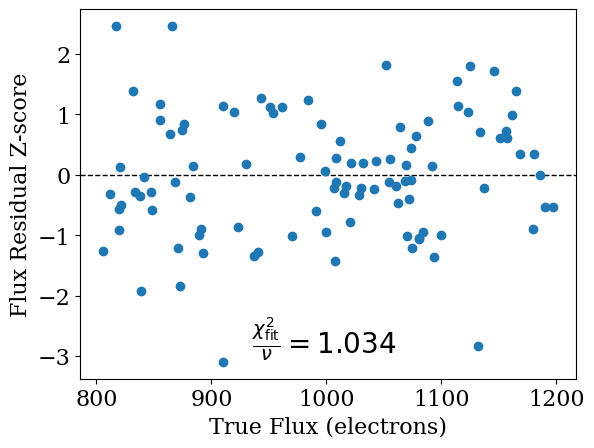

In [11]:
diff = (f_means_with_b-true_fluxes)
indv_chi2 = np.sum((np.power(diff/np.sqrt(1/f_ivars_with_b),2)))

fluxes_fit_scaled_chi2 = indv_chi2/len(diff)
chi2_label = r'$\frac{\chi_{\mathrm{fit}}^2}{\nu} = %.3f$'%fluxes_fit_scaled_chi2



pixel_inds = np.arange(n_pixels)

# plt.errorbar(true_fluxes,f_max_means_given_b,yerr=np.sqrt(1/f_max_ivars_given_b),fmt='o',label='Best Fit')
plt.errorbar(true_fluxes,f_means_with_b,yerr=np.sqrt(1/f_ivars_with_b),fmt='o',label=r'Best Fit')
# plt.errorbar(true_fluxes,f_means_with_b,yerr=np.sqrt(1/f_ivars_with_b),fmt='o',label=r'Best Fit, with $\vec b$')
# plt.errorbar(true_fluxes,f_means_no_b,yerr=np.sqrt(1/f_ivars_no_b),fmt='o',label=r'Best Fit, no $\vec b$')
plt.xlabel('True Flux (electrons)')
plt.ylabel('Measured Flux (electrons)')
leg = plt.legend(loc='best')
xlim = plt.xlim()
ylim = plt.ylim()
line_xy = [min(xlim[0],ylim[0]),max(xlim[1],ylim[1])]
plt.plot(line_xy,line_xy,c='k',ls='--',lw=1)
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()

# plt.errorbar(true_fluxes,f_max_means_given_b-true_fluxes,yerr=np.sqrt(1/f_max_ivars_given_b),fmt='o')
plt.errorbar(true_fluxes,f_means_with_b-true_fluxes,yerr=np.sqrt(1/f_ivars_with_b),fmt='o')
plt.axhline(0,c='k',ls='--',lw=1)
plt.xlabel('True Flux (electrons)')
plt.ylabel('Flux Residual (electrons)')
plt.show()

zscores = (f_means_with_b-true_fluxes)*np.sqrt(f_ivars_with_b)
# plt.errorbar(true_fluxes,(f_max_means_given_b-true_fluxes)*np.sqrt(f_max_ivars_given_b),fmt='o')
plt.errorbar(true_fluxes,zscores,fmt='o')
plt.text(np.mean(true_fluxes),np.min(zscores),
         chi2_label,va='bottom',ha='center',fontsize=20)
plt.axhline(0,c='k',ls='--',lw=1)
plt.xlabel('True Flux (electrons)')
plt.ylabel('Flux Residual Z-score')
plt.show()


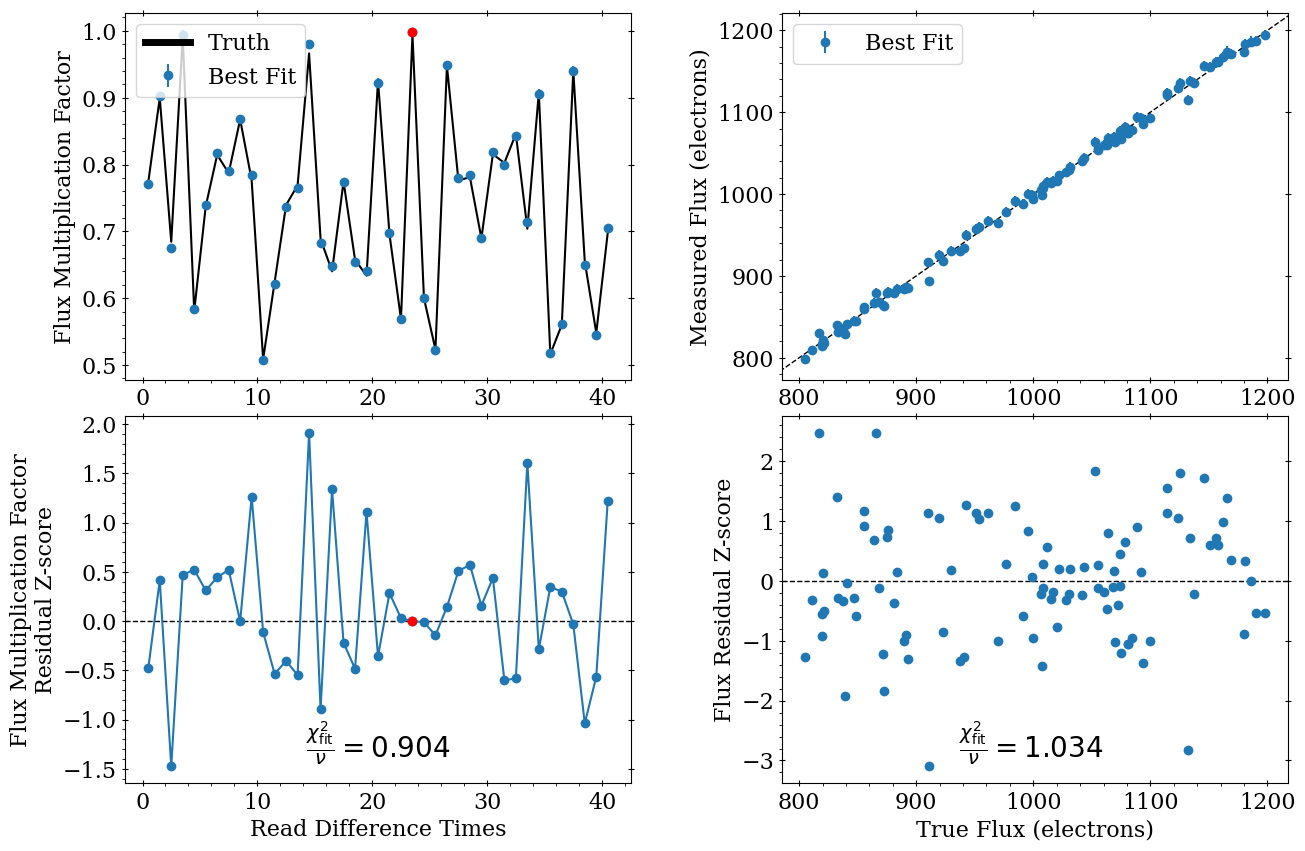

In [12]:
plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(2,2,wspace=0.3,hspace=0.1)
ax = plt.subplot(gs[0,0])    
plt.minorticks_on()
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)

diff = (b_vect_mean-true_b_vect)[non_max_inds]
full_chi2 = np.dot(np.dot(diff,b_vect_Vinv[non_max_inds][:,non_max_inds]),diff)

b_vect_fit_scaled_chi2 = full_chi2/len(diff)
chi2_label = r'$\frac{\chi_{\mathrm{fit}}^2}{\nu} = %.3f$'%b_vect_fit_scaled_chi2

plt.errorbar(read_diff_times,b_vect_mean,yerr=b_vect_errs,fmt='o',label='Best Fit')
plt.errorbar(read_diff_times[max_b_ind],b_vect_mean[max_b_ind],
             yerr=b_vect_errs[max_b_ind],
             fmt='o',color='r')
plt.plot(read_diff_times,true_b_vect,label='Truth',c='k')
# plt.xlabel('Read Difference Times')
plt.ylabel('Flux Multiplication Factor')
leg = plt.legend(loc='best')
for line in leg.get_lines():
    line.set_linewidth(5)



ax = plt.subplot(gs[1,0])    
plt.minorticks_on()
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)

z_scores = (b_vect_mean-true_b_vect)/b_vect_errs
plt.errorbar(read_diff_times,z_scores,fmt='-o')
plt.errorbar(read_diff_times[max_b_ind],z_scores[max_b_ind],
             fmt='-o',color='r')
plt.text(np.mean(read_diff_times),np.min(z_scores),
         chi2_label,va='bottom',ha='center',fontsize=20)
plt.axhline(0,c='k',ls='--',lw=1)
plt.xlabel('Read Difference Times')
plt.ylabel('Flux Multiplication Factor\nResidual Z-score')

ax = plt.subplot(gs[0,1])    
plt.minorticks_on()
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)

diff = (f_means_with_b-true_fluxes)
indv_chi2 = np.sum((np.power(diff/np.sqrt(1/f_ivars_with_b),2)))

fluxes_fit_scaled_chi2 = indv_chi2/len(diff)
chi2_label = r'$\frac{\chi_{\mathrm{fit}}^2}{\nu} = %.3f$'%fluxes_fit_scaled_chi2

pixel_inds = np.arange(n_pixels)

# plt.errorbar(true_fluxes,f_max_means_given_b,yerr=np.sqrt(1/f_max_ivars_given_b),fmt='o',label='Best Fit')
plt.errorbar(true_fluxes,f_means_with_b,yerr=np.sqrt(1/f_ivars_with_b),fmt='o',label=r'Best Fit')
# plt.errorbar(true_fluxes,f_means_with_b,yerr=np.sqrt(1/f_ivars_with_b),fmt='o',label=r'Best Fit, with $\vec b$')
# plt.errorbar(true_fluxes,f_means_no_b,yerr=np.sqrt(1/f_ivars_no_b),fmt='o',label=r'Best Fit, no $\vec b$')
# plt.xlabel('True Flux (electrons)')
plt.ylabel('Measured Flux (electrons)')
leg = plt.legend(loc='best')
xlim = plt.xlim()
ylim = plt.ylim()
line_xy = [min(xlim[0],ylim[0]),max(xlim[1],ylim[1])]
plt.plot(line_xy,line_xy,c='k',ls='--',lw=1)
plt.xlim(xlim)
plt.ylim(ylim)

ax = plt.subplot(gs[1,1])    
plt.minorticks_on()
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)


zscores = (f_means_with_b-true_fluxes)*np.sqrt(f_ivars_with_b)
# plt.errorbar(true_fluxes,(f_max_means_given_b-true_fluxes)*np.sqrt(f_max_ivars_given_b),fmt='o')
plt.errorbar(true_fluxes,zscores,fmt='o')
plt.text(np.mean(true_fluxes),np.min(zscores),
         chi2_label,va='bottom',ha='center',fontsize=20)
plt.axhline(0,c='k',ls='--',lw=1)
plt.xlabel('True Flux (electrons)')
plt.ylabel('Flux Residual Z-score')

plt.savefig(f'{plotpath}single_fit_output_comparison.png')
plt.show()


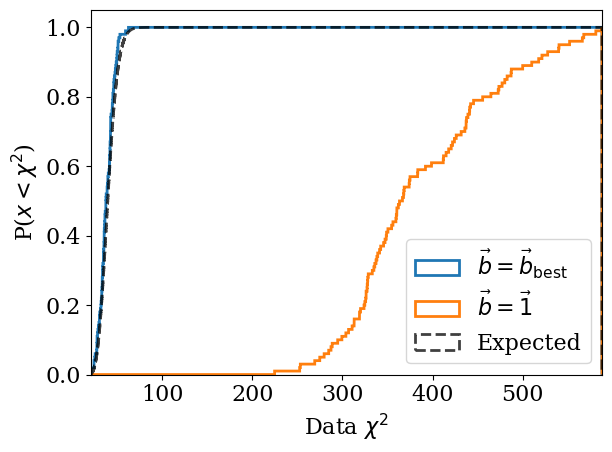

In [13]:
lw = 2
alpha = 1.0
cumulative = True

hist_range = [min(np.min(chi2s_data_with_b),np.min(chi2s_data_no_b)),\
              max(np.max(chi2s_data_with_b),np.max(chi2s_data_no_b))]

hist = plt.hist(chi2s_data_with_b,
         histtype='step',cumulative=cumulative,
         density=True,bins=10000,range=hist_range,
         label=r'$\vec b = \vec b_{\mathrm{best}}$',
         lw=lw,alpha=alpha)
hist_bins = hist[1]
hist_bin_centers = 0.5*(hist_bins[1:]+hist_bins[:-1])

plt.hist(chi2s_data_no_b,
         histtype='step',cumulative=cumulative,
         density=True,bins=10000,range=hist_range,
         label=r'$\vec b = \vec 1$',
         lw=lw,alpha=alpha)
expect_weights = np.diff(stats.chi2(loc=0,scale=1,df=n_reads-2).cdf(hist_bins))
expect_weights /= np.sum(expect_weights)
plt.hist(hist_bin_centers,weights=expect_weights,histtype='step',
         density=True,bins=hist_bins,cumulative=cumulative,color='k',
        label='Expected',lw=lw,alpha=0.75,ls='--')
leg = plt.legend(loc='best')
plt.xlim(hist_range[0],hist_range[1])
plt.xlabel('Data $\chi^2$')
plt.ylabel('P($x < \chi^2$)')
plt.tight_layout()
plt.savefig(f'{plotpath}single_fit_data_chi2.png')
plt.show()


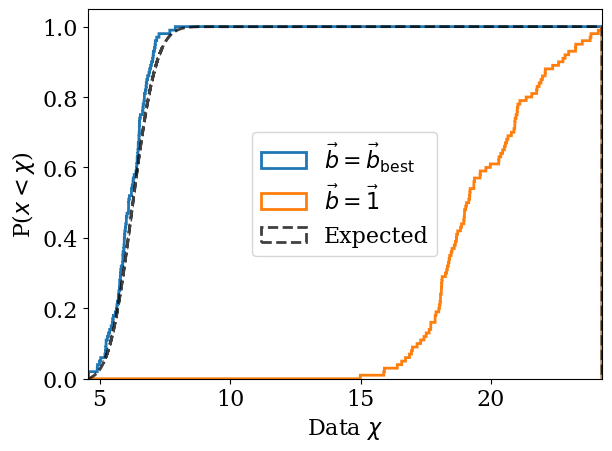

In [14]:
lw = 2
alpha = 1.0
cumulative = True

hist_range = [min(np.min(chi2s_data_with_b),np.min(chi2s_data_no_b)),\
              max(np.max(chi2s_data_with_b),np.max(chi2s_data_no_b))]
hist_range = np.sqrt(np.array(hist_range))

hist = plt.hist(np.sqrt(chi2s_data_with_b),
         histtype='step',cumulative=cumulative,
         density=True,bins=10000,range=hist_range,
         label=r'$\vec b = \vec b_{\mathrm{best}}$',
         lw=lw,alpha=alpha)
hist_bins = hist[1]
hist_bin_centers = 0.5*(hist_bins[1:]+hist_bins[:-1])

plt.hist(np.sqrt(chi2s_data_no_b),
         histtype='step',cumulative=cumulative,
         density=True,bins=10000,range=hist_range,
         label=r'$\vec b = \vec 1$',
         lw=lw,alpha=alpha)
expect_weights = np.diff(stats.chi(loc=0,scale=1,df=n_reads-2).cdf(hist_bins))
expect_weights /= np.sum(expect_weights)
plt.hist(hist_bin_centers,weights=expect_weights,histtype='step',
         density=True,bins=hist_bins,cumulative=cumulative,color='k',
        label='Expected',lw=lw,alpha=0.75,ls='--')
leg = plt.legend(loc='best')
plt.xlabel('Data $\chi$')
plt.ylabel('P($x < \chi$)')
plt.xlim(hist_range[0],hist_range[1])
plt.tight_layout()
plt.savefig(f'{plotpath}single_fit_data_chi.png')
plt.show()


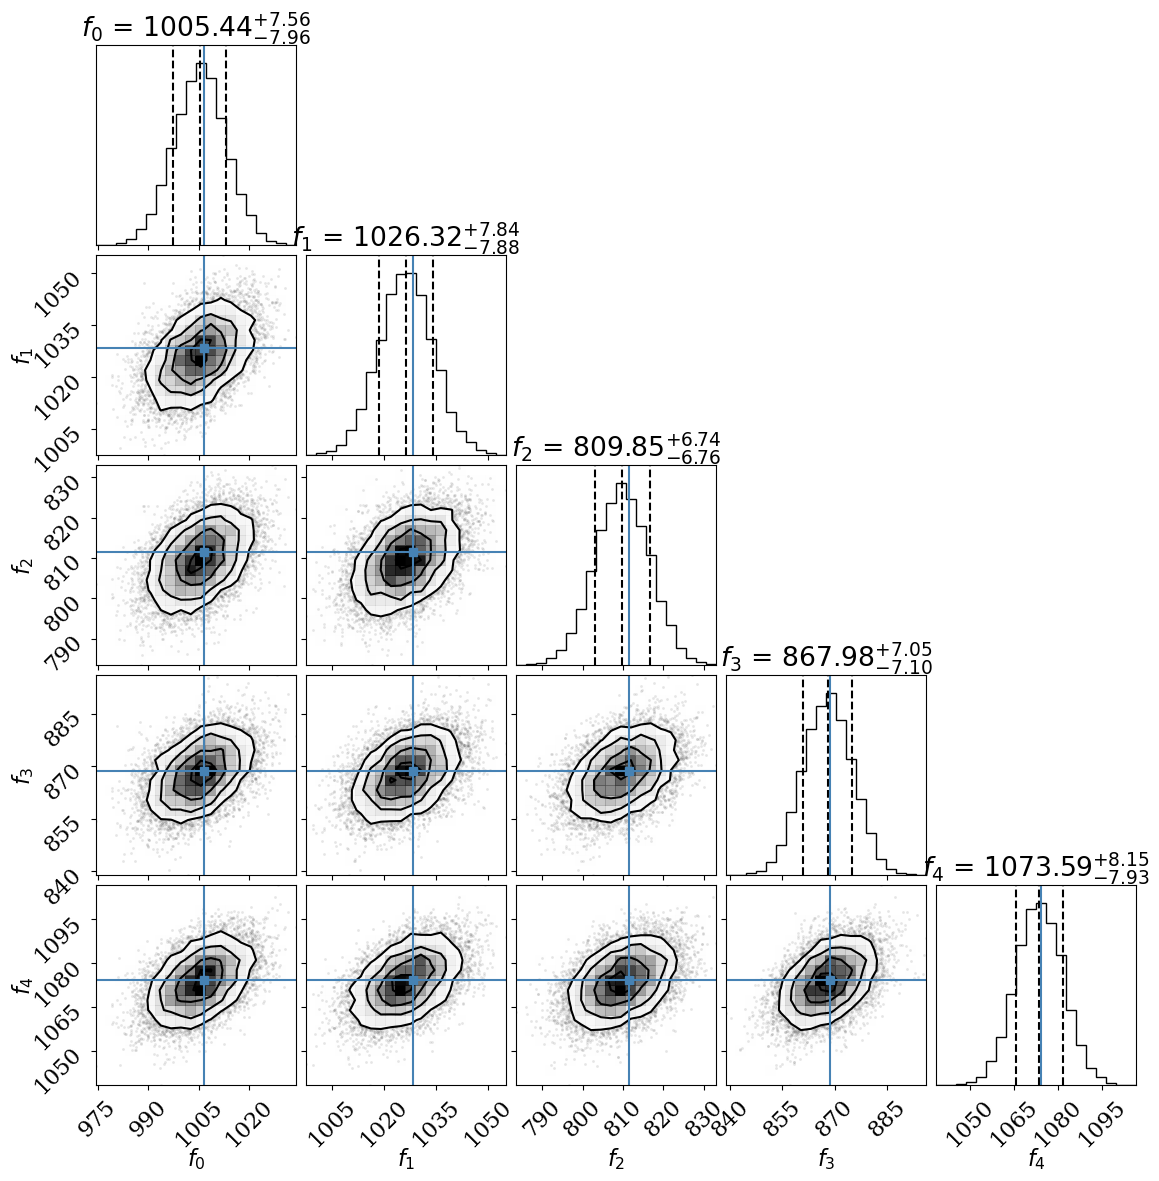

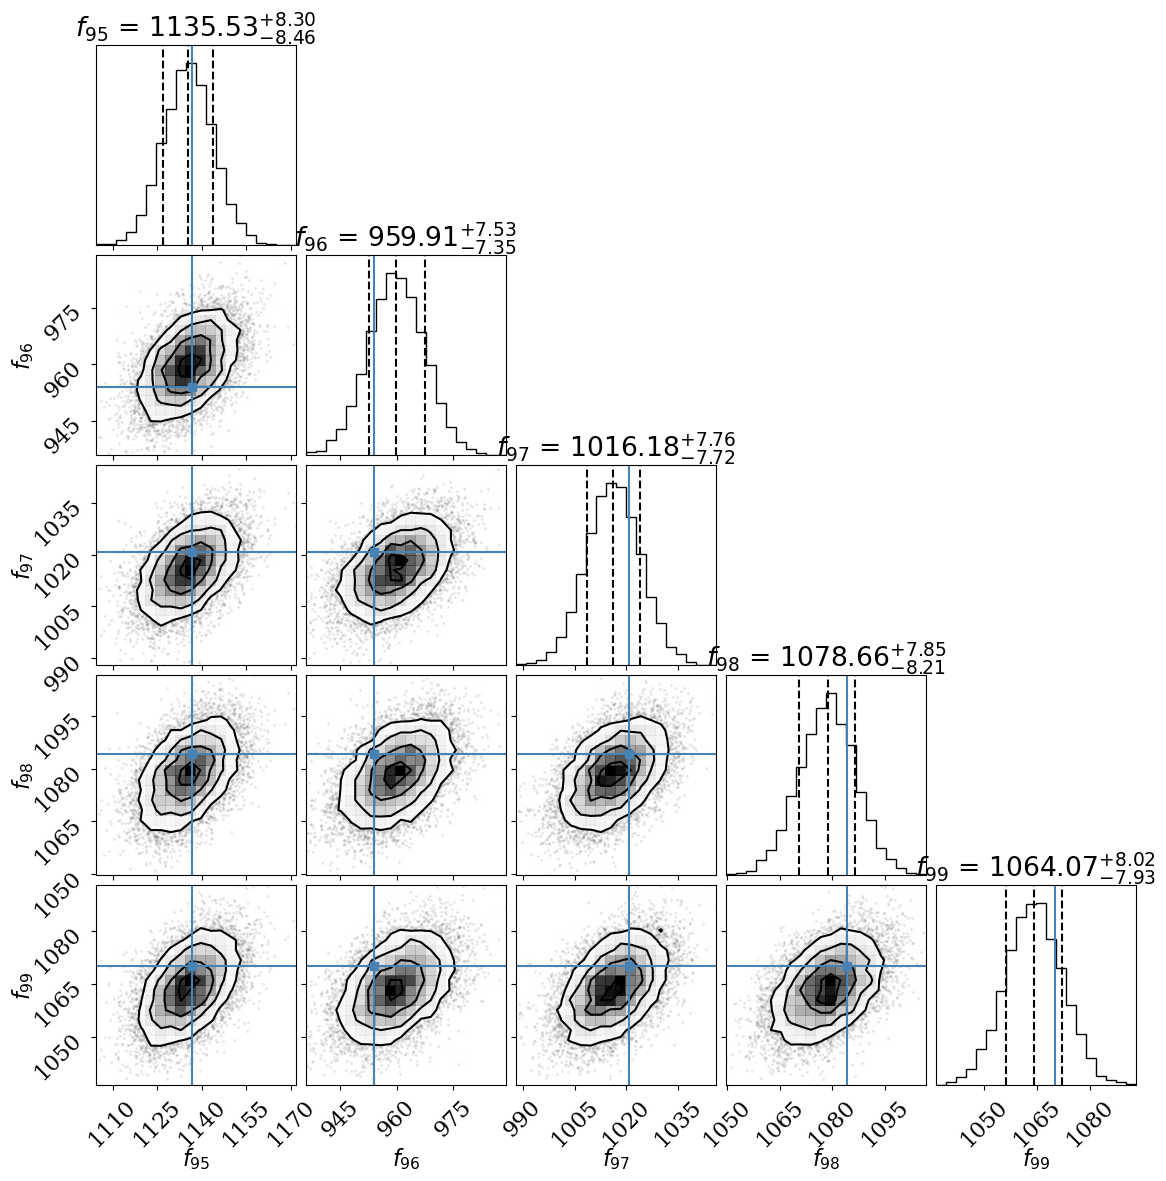

In [15]:
#f vector plots


plot_inds = np.arange(0,5).astype(int)
labels = []
for plot_ind in plot_inds:
    labels.append('$f_{%d}$'%plot_ind)
corner.corner(comb_param_samps[:,plot_inds],
              show_titles=True,quantiles=[0.16,0.50,0.84],
              truths=true_param_means[plot_inds],labels=labels,
              fontsize=14)
plt.show()
plot_inds = np.arange(-5,0).astype(int)+n_pixels
labels = []
for plot_ind in plot_inds:
    labels.append('$f_{%d}$'%plot_ind)
corner.corner(comb_param_samps[:,plot_inds],
              show_titles=True,quantiles=[0.16,0.50,0.84],
              truths=true_param_means[plot_inds],labels=labels)
plt.show()

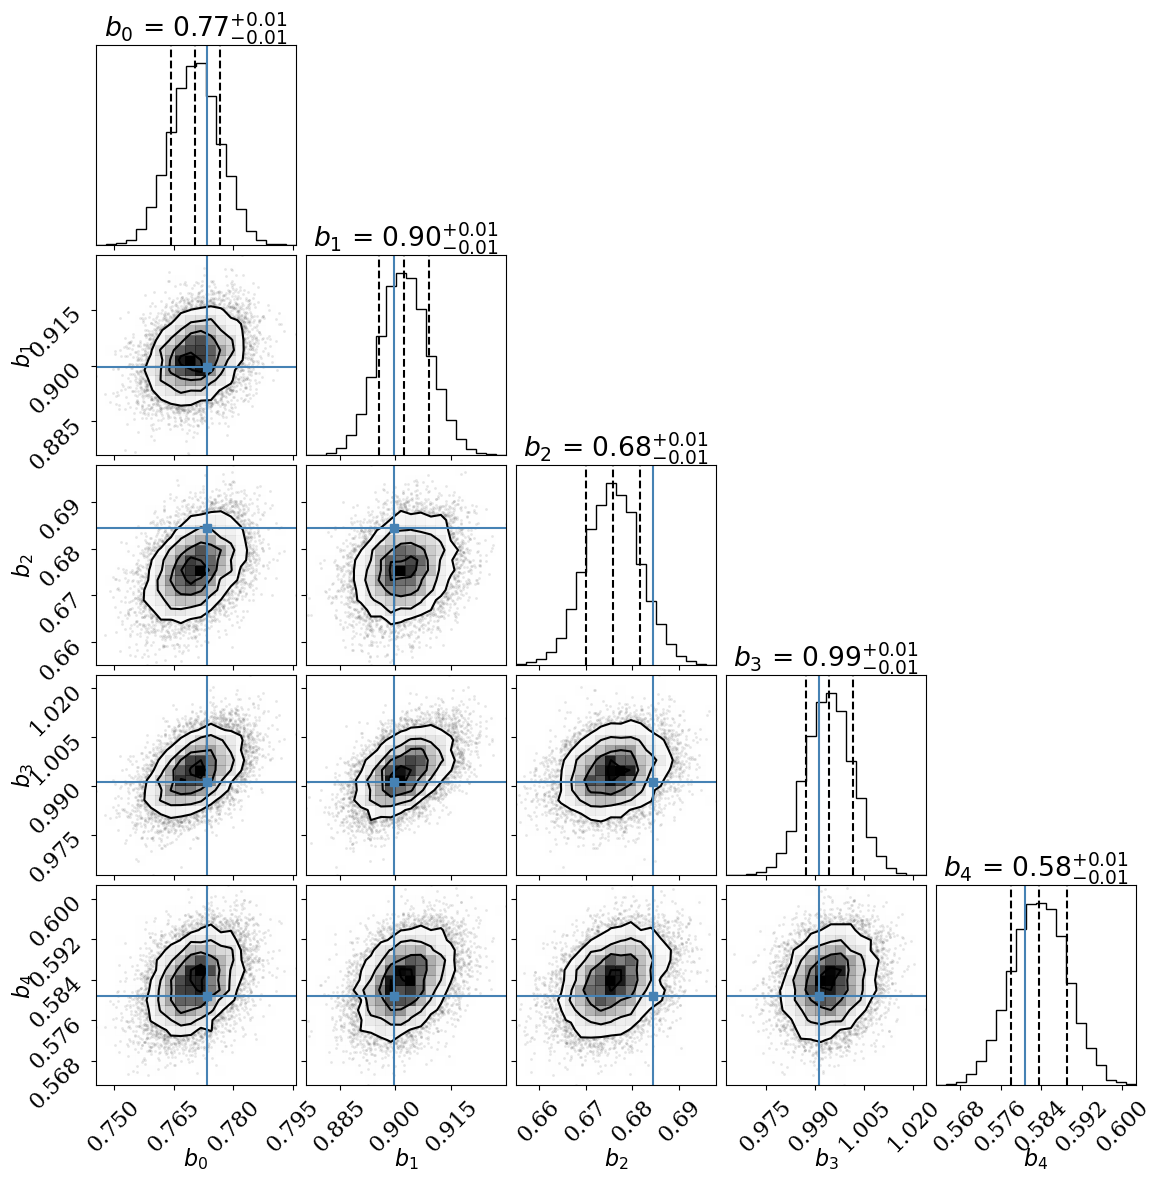

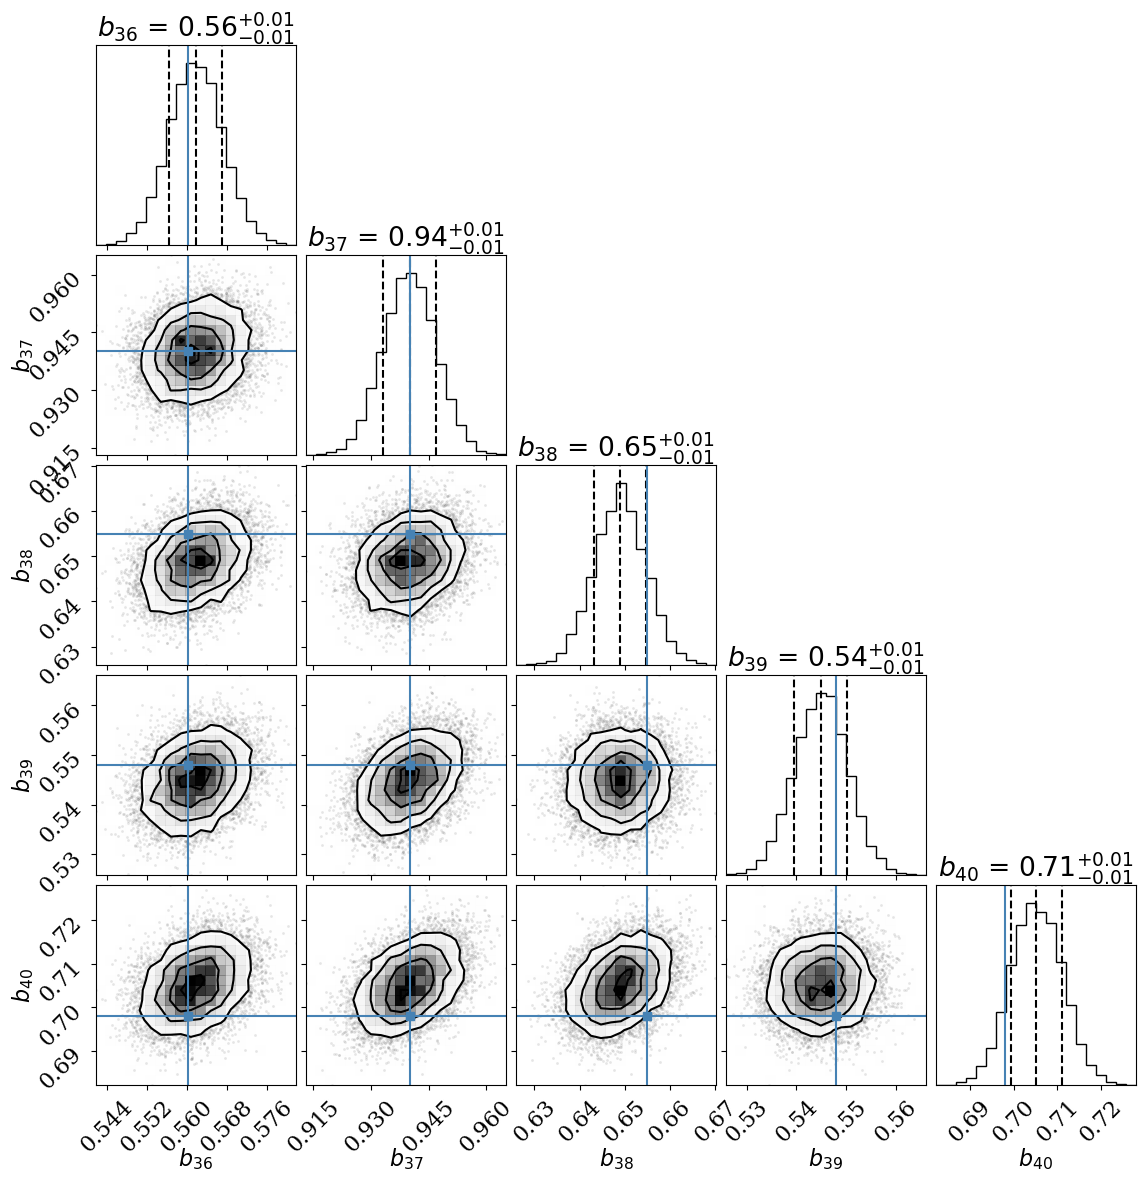

In [16]:
#b vector plots

plot_inds = np.arange(0,5).astype(int)+n_pixels
labels = []
for plot_ind in plot_inds:
    labels.append('$b_{%d}$'%non_max_inds[plot_ind-n_pixels])
corner.corner(comb_param_samps[:,plot_inds],
              show_titles=True,quantiles=[0.16,0.50,0.84],
              truths=true_param_means[plot_inds],labels=labels)
plt.show()
plot_inds = non_max_inds[-5:]+n_pixels-1
labels = []
for plot_ind in plot_inds:
    labels.append('$b_{%d}$'%non_max_inds[plot_ind-n_pixels])

corner.corner(comb_param_samps[:,plot_inds],
              show_titles=True,quantiles=[0.16,0.50,0.84],
              truths=true_param_means[plot_inds],labels=labels)
plt.show()

[0 1]


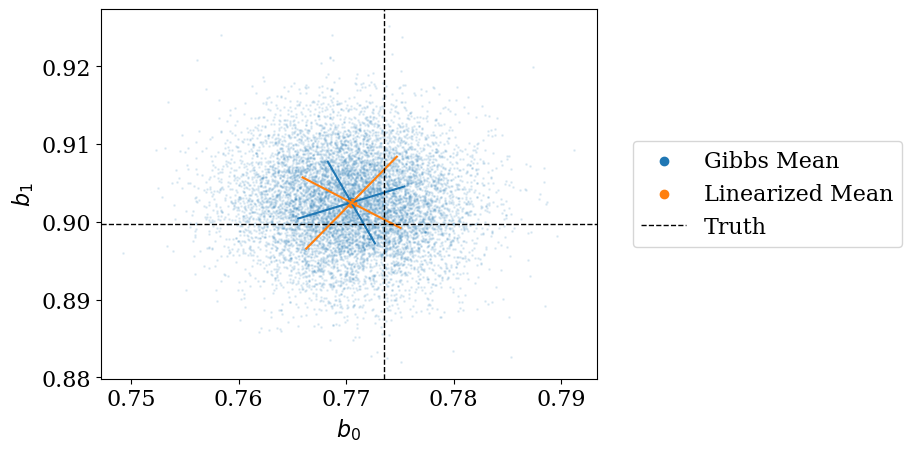

In [17]:
b_inds = np.array([0,1])
# b_inds = np.array([36,37])-1
orig_b_inds = non_max_inds[b_inds]
comb_inds = b_inds+n_pixels
true_param_means

print(orig_b_inds)

plt.scatter(comb_param_samps_gibbs[:,comb_inds[0]],
            comb_param_samps_gibbs[:,comb_inds[1]],
            s=1,alpha=0.1)
# plt.scatter(comb_param_samps_linear[:,comb_inds[0]],
#             comb_param_samps_linear[:,comb_inds[1]],
#             s=1,alpha=0.1)

curr_med = b_vect_mean_gibbs[orig_b_inds]
curr_cov = np.zeros((2,2))
curr_cov[0,0] = b_vect_cov_gibbs[orig_b_inds[0],orig_b_inds[0]]
curr_cov[0,1] = b_vect_cov_gibbs[orig_b_inds[0],orig_b_inds[1]]
curr_cov[1,0] = b_vect_cov_gibbs[orig_b_inds[1],orig_b_inds[0]]
curr_cov[1,1] = b_vect_cov_gibbs[orig_b_inds[1],orig_b_inds[1]]
curr_vals,curr_vects = np.linalg.eig(curr_cov)
curr_vals = np.sqrt(curr_vals)
err_vects = np.zeros_like(curr_vects)
err_vects[0] = curr_vals[0]*curr_vects[:,0]
err_vects[1] = curr_vals[1]*curr_vects[:,1]    

err1_plot = [curr_med[0]-err_vects[0,0],curr_med[0]+err_vects[0,0]],\
            [curr_med[1]-err_vects[0,1],curr_med[1]+err_vects[0,1]]
err2_plot = [curr_med[0]-err_vects[1,0],curr_med[0]+err_vects[1,0]],\
            [curr_med[1]-err_vects[1,1],curr_med[1]+err_vects[1,1]]
color = 'C0'
plt.scatter(curr_med[0],curr_med[1],
            marker='o',label='Gibbs Mean',color=color)
plt.plot(err1_plot[0],err1_plot[1],color=color)
plt.plot(err2_plot[0],err2_plot[1],color=color)

curr_med = b_vect_mean_linear[orig_b_inds]
curr_cov = np.zeros((2,2))
curr_cov[0,0] = b_vect_cov_linear[orig_b_inds[0],orig_b_inds[0]]
curr_cov[0,1] = b_vect_cov_linear[orig_b_inds[0],orig_b_inds[1]]
curr_cov[1,0] = b_vect_cov_linear[orig_b_inds[1],orig_b_inds[0]]
curr_cov[1,1] = b_vect_cov_linear[orig_b_inds[1],orig_b_inds[1]]
curr_vals,curr_vects = np.linalg.eig(curr_cov)
curr_vals = np.sqrt(curr_vals)
err_vects = np.zeros_like(curr_vects)
err_vects[0] = curr_vals[0]*curr_vects[:,0]
err_vects[1] = curr_vals[1]*curr_vects[:,1]    

err1_plot = [curr_med[0]-err_vects[0,0],curr_med[0]+err_vects[0,0]],\
            [curr_med[1]-err_vects[0,1],curr_med[1]+err_vects[0,1]]
err2_plot = [curr_med[0]-err_vects[1,0],curr_med[0]+err_vects[1,0]],\
            [curr_med[1]-err_vects[1,1],curr_med[1]+err_vects[1,1]]
color = 'C1'
plt.scatter(curr_med[0],curr_med[1],
            marker='o',label='Linearized Mean',color=color)
plt.plot(err1_plot[0],err1_plot[1],color=color)
plt.plot(err2_plot[0],err2_plot[1],color=color)

# plt.errorbar(b_vect_mean_gibbs[orig_b_inds[0]],b_vect_mean_gibbs[orig_b_inds[1]],
#              xerr=b_vect_errs_gibbs[orig_b_inds[0]],
#              yerr=b_vect_errs_gibbs[orig_b_inds[1]],
#              fmt='o',label='Gibbs Mean')
# plt.errorbar(b_vect_mean_linear[orig_b_inds[0]],b_vect_mean_linear[orig_b_inds[1]],
#              xerr=b_vect_errs_linear[orig_b_inds[0]],
#              yerr=b_vect_errs_linear[orig_b_inds[1]],
#              fmt='o',label='Linearized Mean')
plt.axhline(true_param_means[comb_inds[1]],c='k',lw=1,ls='--',label='Truth')
plt.axvline(true_param_means[comb_inds[0]],c='k',lw=1,ls='--')
plt.xlabel('$b_{%d}$'%orig_b_inds[0])
plt.ylabel('$b_{%d}$'%orig_b_inds[1])
plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
plt.show()
